# Simple baseline algorithm to get some start point

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot

%matplotlib inline

import random # only need to generate random pedestrians

I got data from [here](http://www.ee.cuhk.edu.hk/~syi/). It includes folder Annotation (now Csv) (which consists of txt-file describing path for each of 12684 pedestrians) and folder Frame (6001 frames with pictures of observed area).

In [18]:
# amount of data in src/Csv folder
NUMBER_OF_PEDESTRIANS = 12684

TRAIN_NUMBER = 10569
TEST_NUMBER = 2115

assert TRAIN_NUMBER + TEST_NUMBER == NUMBER_OF_PEDESTRIANS

In [42]:
# input consists of list of points
# function get some two of them (the last one and %start_point%), build a vector with the same direction
# and returns %number_of_points_to_return% points (5 by default) on this vector with equal distance between them
# distance can be equal to last vector distance (by default) or to mean distance of all vectors (mean_distance=True)

def get_vector_linear_continuation(input_list, start_point_index, number_of_points_to_return=5, mean_distance=False):
    error_template = "Start point index should be less than last point. Start point index: {st}, last point index: {end}"
    assert (start_point_index < len(input_list) - 1), error_template.format(st=start_point_index, end=len(input_list) - 1)
    start_point = np.array(input_list)[start_point_index]
    end_point = np.array(input_list)[-1]
    normalized_motion_vector = (end_point - start_point) / np.linalg.norm(end_point - start_point)
    if mean_distance:
        distance = 0
        for i in range(len(input_list) - 1):
            distance += np.linalg.norm(np.array(input_list)[i + 1] - np.array(input_list)[i])
        distance /= len(input_list) - 1
    else:
        distance = np.linalg.norm(end_point - np.array(input_list)[-2])
    motion_vector = normalized_motion_vector * distance
    result = []
    for i in range(number_of_points_to_return):
        result.append(end_point + (i + 1) * motion_vector)
    return result

In [7]:
def download_pedestrian(index):
    error_message_template = "Pedestrian number should be between 1 and {max}; given number: {id}"
    assert(1 <= index <= NUMBER_OF_PEDESTRIANS), error_message_template.format(max=NUMBER_OF_PEDESTRIANS, id=index)
    filename = "src/Csv/{}.txt".format(str(index).zfill(ZERO_PADDING))
    data = pd.read_csv(filename, index_col=0)
    return data

In [25]:
# in each row: {index; category; frames_number; label}
labels = pd.read_csv('src/pedestrian_labels_and_test_and_train_separation.csv', index_col=0)

Here we will get some data such as mean frames for pedestrians or difference between real pedestrian's coordinates and predicted through get_vector_linear_continuation with different paremeters.

In [28]:
labels['frames_number'].mean(), labels['frames_number'].min(), labels['frames_number'].max()

(35.98312835067802, 1, 995)

In [56]:
difference_false_mean_distance = pd.DataFrame(columns=[str(i + 1) for i in range(4)])
difference_true_mean_distance = pd.DataFrame(columns=[str(i + 1) for i in range(4)])

for index in range(1, NUMBER_OF_PEDESTRIANS + 1):
    if labels['category'][index] == 'train':
        continue
    
    # in each row: {index (time); X; Y}
    data = download_pedestrian(index)
    input_list = data[:5]
    output_list = data[5:10]
    
    # if way of pedestrian is shorter than ten coordinates
    if input_list.shape[0] + output_list.shape[0] != 10:
        print('Attention: index {id} in category "test" but contains less than ten frames'.format(id=index))
        print('It contains {} frames'.format((input_list.shape[0] + output_list.shape[0])))
        continue
        
    real_coordinates = np.array(output_list)
    
    false_mean_distance = []
    true_mean_distance = []
        
    for i in range(4):
        predicted_false = np.array(get_vector_linear_continuation(input_list, start_point_index=i))
        predicted_true = np.array(get_vector_linear_continuation(input_list, start_point_index=i, mean_distance=True))

        false_mean_distance.append(sum([np.linalg.norm(predicted_false[i] - real_coordinates[i]) for i in range(5)]))
        true_mean_distance.append(sum([np.linalg.norm(predicted_true[i] - real_coordinates[i]) for i in range(5)]))
            
    false_mean_distance = pd.Series(false_mean_distance, index=[str(i + 1) for i in range(4)])
    true_mean_distance = pd.Series(true_mean_distance, index=[str(i + 1) for i in range(4)])
        
    difference_false_mean_distance = difference_false_mean_distance.append(false_mean_distance, ignore_index=True)  
    difference_true_mean_distance = difference_true_mean_distance.append(true_mean_distance, ignore_index=True)

Attention: index 13 in category "test" but contains less than ten frames
It contains 3 frames
Attention: index 53 in category "test" but contains less than ten frames
It contains 8 frames
Attention: index 59 in category "test" but contains less than ten frames
It contains 6 frames
Attention: index 387 in category "test" but contains less than ten frames
It contains 9 frames
Attention: index 445 in category "test" but contains less than ten frames
It contains 7 frames
Attention: index 600 in category "test" but contains less than ten frames
It contains 7 frames
Attention: index 671 in category "test" but contains less than ten frames
It contains 9 frames
Attention: index 783 in category "test" but contains less than ten frames
It contains 9 frames
Attention: index 839 in category "test" but contains less than ten frames
It contains 9 frames
Attention: index 1044 in category "test" but contains less than ten frames
It contains 7 frames
Attention: index 2174 in category "test" but contain

In [58]:
difference_false_mean_distance.to_csv('src/Logs/160925_difference_false_mean_distance.csv')
difference_true_mean_distance.to_csv('src/Logs/160925_difference_true_mean_distance.csv')

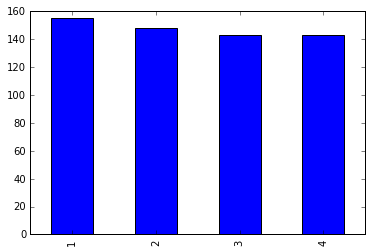

In [67]:
difference_false_mean_distance.mean().plot.bar()

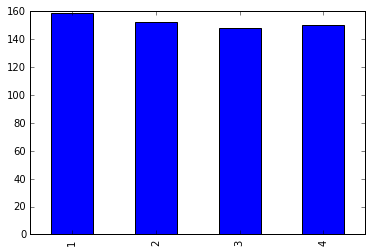

In [68]:
difference_true_mean_distance.mean().plot.bar()

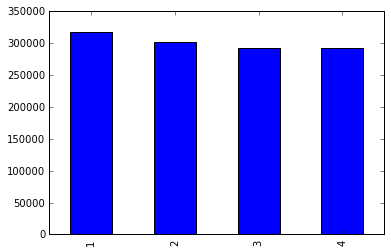

In [69]:
difference_false_mean_distance.sum().plot.bar()

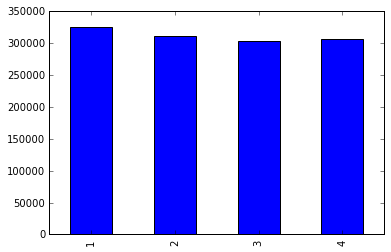

In [70]:
difference_true_mean_distance.sum().plot.bar()